# Module Imports

In [1]:
import os

import pandas as pd

# Loading the data

##### Using OS module to determine filepaths in OS independent manner as backslashes used on Windows and forward slashes used on Unix

In [2]:
working_directory = os.path.abspath('')

In [3]:
training_data_location = os.path.join(working_directory, 'Data', 'train.csv')
testing_data_location = os.path.join(working_directory, 'Data', 'test.csv')

In [4]:
titanic_training_data = pd.read_csv(training_data_location)
titanic_testing_data = pd.read_csv(training_data_location)

# Initial data exploration

In [5]:
titanic_training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Training data consist of the following columns:

    1) Passenger ID: Assuming this is unique
    2) Survived: This is a true(1)/false(0) of whether or not the passenger has survived
    3) Pclass: class of ticket, this is either lower (3), middle (2) or upper (1)
    4) Name: Passenger name as a string. It may be worth splitting passenger name into surnames to see if we can group by families
    5) Sex: categorical of either male or female
    6) SibSp: This is the number of siblings and spouses on-board the titanic
    7) Parch: This is the number of parents and children on-board the titanic
    8) Ticket number: I assume this is unique --> I wonder if there is any processing that can be done to extract more information.
    9) Fare: price paid for ticket
    10) Cabin: Cabin number, maybe this is something to do with location upon the titanic..may require some processing. Or maybe we can make a new column which represents whether or not a person has a Cabin.
    11) Embarked: Location at which person embarked the titanic. S is Southampton, Q is queenstown and C is Cherbourg


## Column Exploration
Before moving on, it is probably a good idea to ask some simple questions based on the columns available to us.

### Impact of sex

In [6]:
titanic_training_data.groupby(['Sex']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


This tells us the following:

    1) More females survived than men.
    2) The ticket price paid by females is higher than men, probably also explains why the ticket class is slightly higher (lower number).
    3) Females tend to be ~3 years younger than men.
    4) Females tend to travel more as families as SibSP and Parch is higher
    
At this stage is looks like sex should be included in models to predict whether or not someone survived.

## Impact of age

In [7]:
titanic_training_data.hist(column='Age', by=['Survived'], bins=10)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B90360A550>,
      dtype=object)

It looks like if you are slightly younger or about 40 years old you are more likely to survive. The histogram isn't providing any numbers so would be useful to generate a statistics table.

In [8]:
temp_df = titanic_testing_data
temp_df.Age = temp_df.Age // 10 * 10 #Splitting age into 10 year brackets
temp_df.groupby(['Age']).mean()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
Age,,,,,,
0.0,424.741935,0.612903,2.629032,1.854839,1.403226,30.576679
10.0,444.362745,0.401961,2.470588,0.666667,0.470588,32.535132
20.0,433.231818,0.350000,2.450000,0.322727,0.250000,27.278937
30.0,472.449102,0.437126,2.113772,0.353293,0.329341,40.377294
40.0,465.606742,0.382022,1.966292,0.370787,0.471910,38.002297
50.0,440.187500,0.416667,1.562500,0.291667,0.270833,47.933333
60.0,433.736842,0.315789,1.473684,0.263158,0.368421,48.367542
70.0,496.500000,0.000000,1.833333,0.166667,0.166667,30.197233
80.0,631.000000,1.000000,1.000000,0.000000,0.000000,30.000000


The above table is hard to visualise so a plot would be more useful.

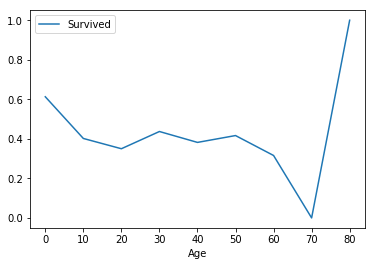

In [9]:
temp_df.groupby(['Age']).mean().plot(y='Survived')

Now it is easier to see that younger people tend to survive more than older people. Surival rate seems to drop from 50 years onwards to about 70 years. Then spikes at 80, however, maybe this is an anomaly? At this stage it looks like age has a small impact, but not nearly as big as sex.

## Impact of ticket class

In [10]:
titanic_training_data.groupby(['Pclass']).mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550
